In [2]:
#Import library pandas dan prophet
import pandas as pd
from prophet import Prophet

#Baca dan tampilkan dataset 'sales.csv' menggunakan read_csv dari library pandas.
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/sales.csv')

#Tampilkan dataframe sales.csv
print(df)



/home/kevinpnjt/olah/env311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


             trx_id    product_id    trx_date  units
0        DQTrx00001  DQProduk-004  2024-01-01      1
1        DQTrx00002  DQProduk-001  2024-01-01      1
2        DQTrx00003  DQProduk-008  2024-01-01      1
3        DQTrx00004  DQProduk-007  2024-01-01      1
4        DQTrx00005  DQProduk-018  2024-01-01      1
...             ...           ...         ...    ...
829257  DQTrx829258  DQProduk-019  2025-09-30      1
829258  DQTrx829259  DQProduk-035  2025-09-30      1
829259  DQTrx829260  DQProduk-019  2025-09-30      1
829260  DQTrx829261  DQProduk-002  2025-09-30      2
829261  DQTrx829262  DQProduk-006  2025-09-30      1

[829262 rows x 4 columns]


## Interpretasi Dataset `sales.csv`

Dataset ini isinya catatan penjualan harian. Dari hasil tampilan awal, ada beberapa kolom penting:

- **trx_id** : nomor unik tiap transaksi (misalnya `DQTrx00001`)  
- **product_id** : kode produk yang dibeli (contoh `DQProduk-004`)  
- **trx_date** : tanggal transaksi, formatnya YYYY-MM-DD (contoh `2024-01-01`)  
- **units** : jumlah unit/pcs produk yang dibeli dalam transaksi itu  

### Ringkasan
- Total datanya lumayan banyak, sekitar **829 ribu transaksi**.  
- Periode transaksi tercatat mulai dari **1 Januari 2024** sampai **30 September 2025**.  
- Tiap baris mewakili satu transaksi, jadi ada info produk apa yang dibeli, kapan belinya, dan jumlah unitnya.  

### Catatan Awal
- Data ini bisa dipakai buat lihat pola penjualan harian atau produk mana yang paling sering dibeli.  
- Karena datanya gede banget, biasanya nanti perlu dijumlahkan dulu (misalnya total penjualan per hari atau per produk) biar lebih gampang dianalisis.  
- Kolom `trx_date` penting banget karena itu yang bakal dipakai buat analisis tren atau forecasting.  


In [3]:
# Import library pandas dan prophet
import pandas as pd
from prophet import Prophet

# Baca dataset
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

# Agregasi tabel dalam bentuk total penjualan per hari
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

# Ubah tipe data kolom waktu menjadi datetime
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

# Ubah nama kolom agar sesuai format Prophet
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

# Tampilkan dataframe 'prophet_df'
print(prophet_df.head())


          ds     y
0 2024-01-01  1485
1 2024-01-02  1406
2 2024-01-03   750
3 2024-01-04   960
4 2024-01-05  1370


## Interpretasi Data Hasil Agregasi

Setelah data penjualan ditotal per hari, hasilnya berubah jadi lebih ringkas.  
Awalnya tiap baris adalah transaksi satuan, sekarang tiap baris mewakili **total unit produk yang terjual di satu hari**.

Contoh hasilnya:

| ds         | y    |
|------------|------|
| 2024-01-01 | 1485 |
| 2024-01-02 | 1406 |
| 2024-01-03 | 750  |
| 2024-01-04 | 960  |
| 2024-01-05 | 1370 |

Keterangan:
- **ds** ‚Üí kolom tanggal (datetime) yang dipakai Prophet sebagai sumbu waktu.  
- **y** ‚Üí total unit terjual pada hari tersebut.  

### Catatan
- Misalnya tanggal 1 Januari 2024 ada **1485 unit** produk yang laku, sedangkan 3 Januari hanya **750 unit**.  
- Data ini lebih cocok buat forecasting, karena sudah dirangkum per hari.  
- Selanjutnya bisa langsung dipakai Prophet untuk bikin model prediksi penjualan ke depan.  


In [4]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library pandas dan prophet
import pandas as pd
from prophet import Prophet

# Baca dataset
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

# Agregasi tabel dalam bentuk total penjualan per hari
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

# Ubah tipe data kolom waktu menjadi datetime
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

# Ubah nama kolom agar sesuai format Prophet (ds untuk tanggal, y untuk target)
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

# Definisikan model prophet
model = Prophet()

# Training model prophet
model.fit(prophet_df)


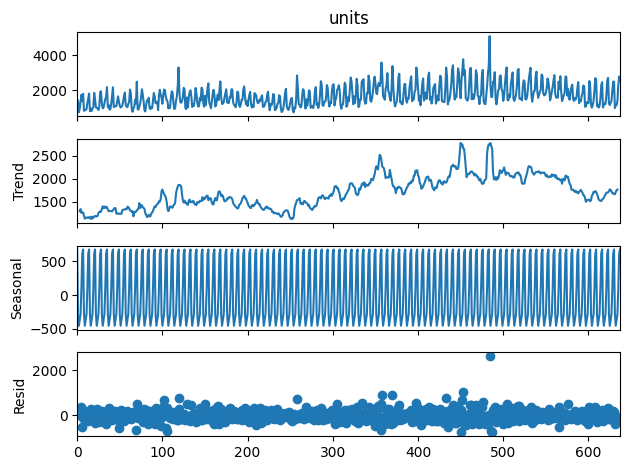

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekomposisi additive (Observed = Trend + Seasonality + Residual)
result = seasonal_decompose(sales_by_date['units'], model='additive', period=7)

# Plot hasil dekomposisi
result.plot()
plt.show()


## Interpretasi Hasil Dekomposisi Time Series

Dari grafik di atas bisa kelihatan beberapa hal:

1. **Data Asli (units)**  
   - Penjualan per hari naik turun cukup tajam.  
   - Ada beberapa lonjakan tinggi banget, kemungkinan karena promo atau event khusus.  

2. **Trend**  
   - Secara umum penjualan cenderung naik, walaupun ada beberapa kali turun di tengah jalan.  
   - Jadi kelihatan kalau makin lama penjualannya cenderung meningkat.  

3. **Seasonal (Musiman)**  
   - Ada pola berulang yang cukup jelas.  
   - Kayaknya pola ini muncul mingguan, misalnya penjualan rame di akhir minggu terus agak sepi di awal minggu.  

4. **Residual (Sisa/Error)**  
   - Sebagian besar titik sisa ini dekat dengan nol, artinya pola trend + musiman sudah cukup mewakili data.  
   - Tapi ada beberapa titik yang jauh banget dari nol, ini bisa dibilang anomali atau kejadian khusus yang nggak biasa.  

### Kesimpulan
Penjualan sehari-hari punya pola naik turun yang teratur, dengan tren jangka panjang yang cenderung naik.  
Selain itu, ada juga pola musiman yang konsisten, ditambah beberapa lonjakan besar yang bisa jadi karena faktor eksternal seperti promo atau hari tertentu.  


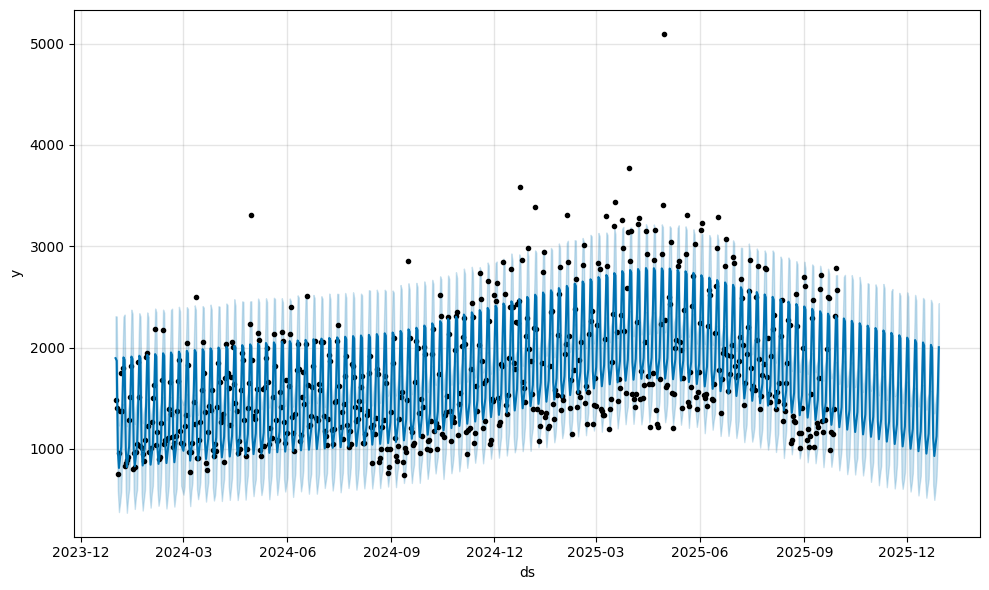

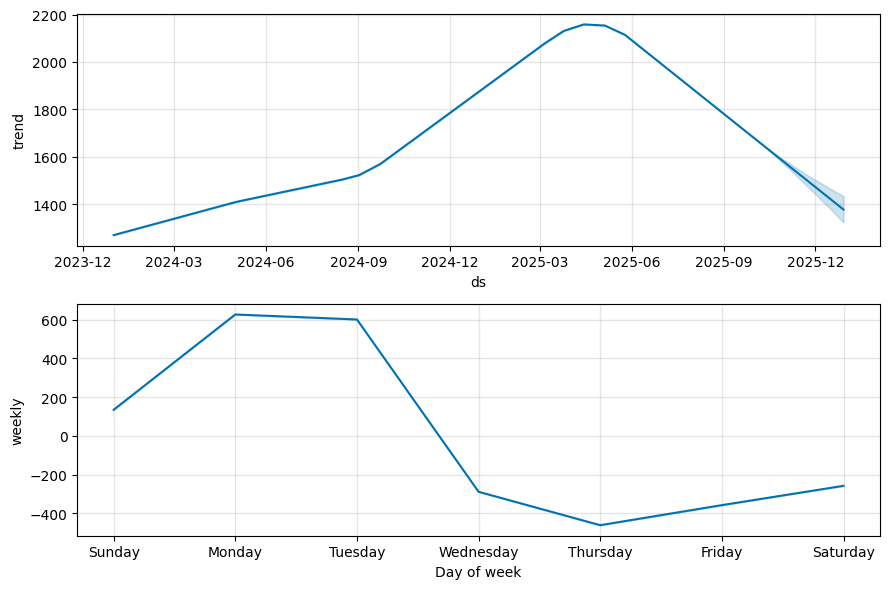

In [6]:
# Membuat dataframe untuk periode waktu ke depan (misalnya 90 hari)
future = model.make_future_dataframe(periods=90)

# Forecasting
forecast = model.predict(future)

# Tampilkan grafik hasil forecast
fig1 = model.plot(forecast)

# Tampilkan grafik komponen (trend, weekly, yearly, dll.)
fig2 = model.plot_components(forecast)


## Interpretasi Hasil Forecast Prophet

Dari grafik hasil forecast bisa dilihat beberapa hal:

1. **Grafik utama (paling atas)**  
   - Titik hitam itu data penjualan asli, garis biru adalah hasil prediksi.  
   - Modelnya cukup ngikutin pola data, walaupun ada beberapa titik yang nyeleneh jauh dari garis (mungkin karena promo atau event khusus).  
   - Secara umum penjualan kelihatan naik terus sampai pertengahan 2025, lalu agak turun menjelang akhir tahun.  

2. **Trend (tengah)**  
   - Garis tren nunjukin penjualan naik pelan-pelan dari awal 2024.  
   - Puncaknya ada di sekitar pertengahan 2025, setelah itu mulai turun sedikit.  
   - Jadi bisa dibilang ada masa "peak" di tengah 2025 sebelum agak melandai lagi.  

3. **Pola mingguan (bawah)**  
   - Penjualan rame di awal minggu (Senin-Selasa).  
   - Mulai turun di Rabu dan Kamis, paling sepi biasanya Rabu.  
   - Menjelang akhir minggu (Jumat-Sabtu) agak naik lagi, tapi nggak setinggi awal minggu.  

### Kesimpulan
Model Prophet bisa nangkep tren naik-turun penjualan dan pola mingguan yang konsisten.  
Ada beberapa titik yang beda banget dari prediksi, kemungkinan besar itu outlier karena faktor luar biasa kayak promo atau event.  


            ds         yhat   yhat_lower   yhat_upper
658 2025-10-21  2211.216493  1785.751304  2664.520880
659 2025-10-22  1319.029440   883.379471  1725.602230
660 2025-10-23  1143.312776   717.359267  1580.354328
661 2025-10-24  1243.425178   823.277618  1683.927964
662 2025-10-25  1339.660876   940.882046  1765.796764
663 2025-10-26  1728.519489  1300.239264  2150.482189
664 2025-10-27  2216.736596  1764.897700  2609.687200
665 2025-10-28  2187.535596  1722.368930  2616.735002
666 2025-10-29  1295.348543   831.518709  1708.907168
667 2025-10-30  1119.631879   676.754555  1560.542134


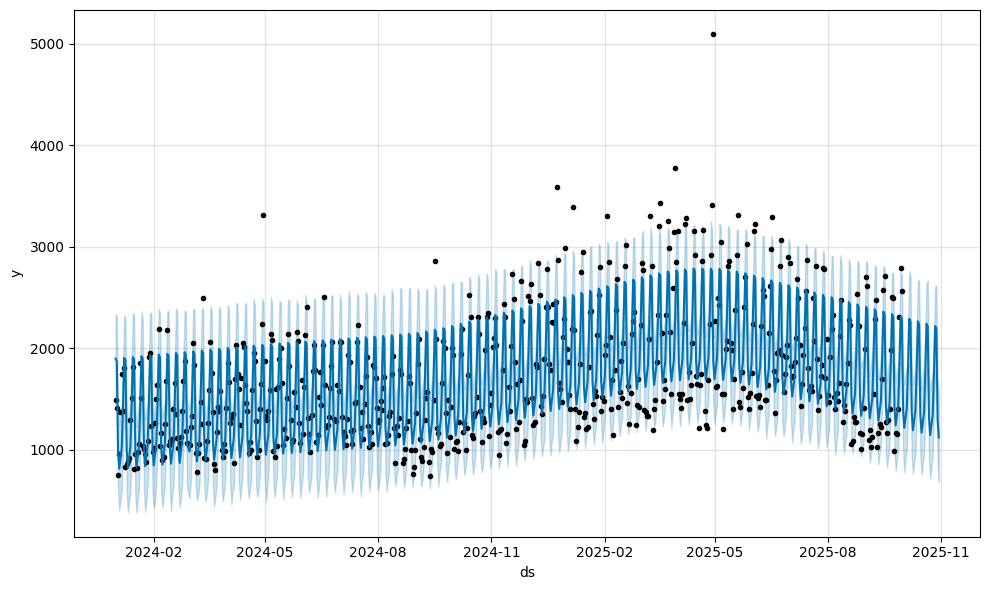

In [7]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

# Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

# Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

# Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

# Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

# Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

# Tampilkan hasil prediksi (beberapa baris terakhir)
print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# Plot hasil forecast
fig1 = model.plot(prediction)
plt.show()


## Interpretasi Hasil Forecast Prophet

Dari hasil prediksi Prophet untuk 30 hari ke depan, tabel di atas nunjukin beberapa hal:

- **ds** ‚Üí tanggal prediksi  
- **yhat** ‚Üí nilai prediksi penjualan (estimasi jumlah unit)  
- **yhat_lower** dan **yhat_upper** ‚Üí batas bawah dan batas atas prediksi (range kemungkinan)  

### Contoh hasil
- Tanggal **21 Oktober 2025**, prediksi penjualan sekitar **2211 unit** (bisa jadi antara 1786 ‚Äì 2665 unit).  
- Tanggal **22 Oktober 2025**, penjualan diperkirakan turun ke sekitar **1319 unit**.  
- Tanggal **26 Oktober 2025** naik lagi ke sekitar **1729 unit**.  
- Tanggal **27 Oktober 2025** diprediksi paling tinggi di minggu itu, sekitar **2217 unit**.  

### Kesimpulan
Prediksi nunjukkin pola naik-turun yang masih konsisten dengan data sebelumnya. Ada hari-hari tertentu (seperti Senin/Selasa) yang lebih tinggi, sementara pertengahan minggu cenderung lebih rendah.  
Dengan hasil ini, bisa dipakai buat **estimasi stok atau strategi promo** di tanggal-tanggal tertentu.  


In [8]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

#Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

#Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

#Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

#Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

#Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

#Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

#Gunakan model.make_future_dataframe(periods=7, freq=‚ÄôD‚Äô) untuk membuat dataframe waktu masa depan dan simpan tabel tersebut dalam variabel future
future = model.make_future_dataframe(periods=7, freq='D')


# Tampilkan dataframe future menggunakan print
print(future)


            ds
0   2024-01-01
1   2024-01-02
2   2024-01-03
3   2024-01-04
4   2024-01-05
..         ...
640 2025-10-03
641 2025-10-04
642 2025-10-05
643 2025-10-06
644 2025-10-07

[645 rows x 1 columns]


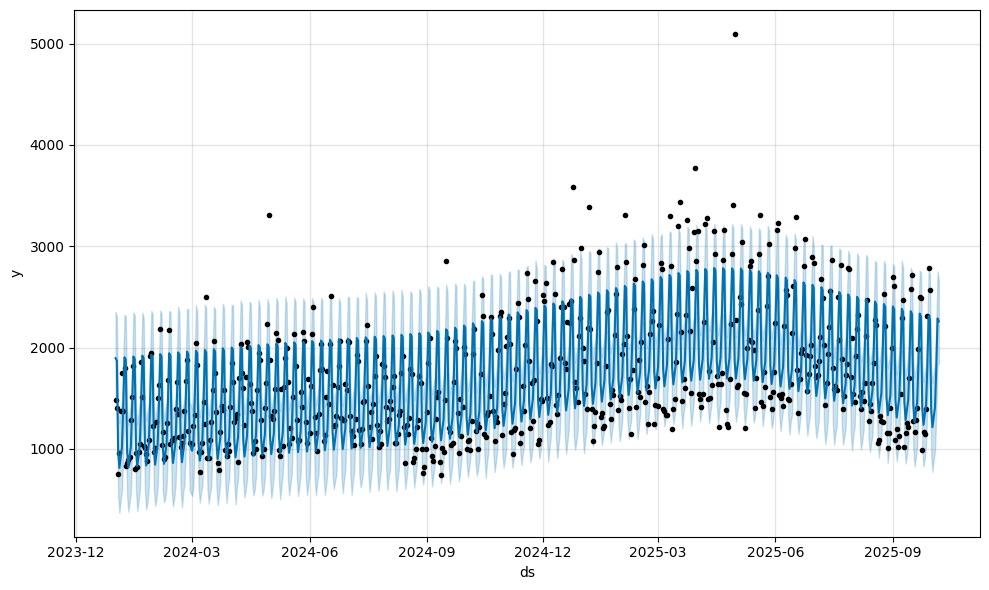

In [9]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

#Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

#Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

#Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

#Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

#Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

#Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

#Gunakan model.make_future_dataframe(periods=7, freq=‚ÄôD‚Äô) untuk membuat dataframe waktu masa depan dan simpan tabel tersebut dalam variabel future
future = model.make_future_dataframe(periods=7, freq='D')

#Lakukan forecasting lagi namun dengan menggunakan dataframe yang baru dibuat
future_prediction = model.predict(future)

#Tampilkan hasil forecasting
fig = model.plot(future_prediction)
plt.show()


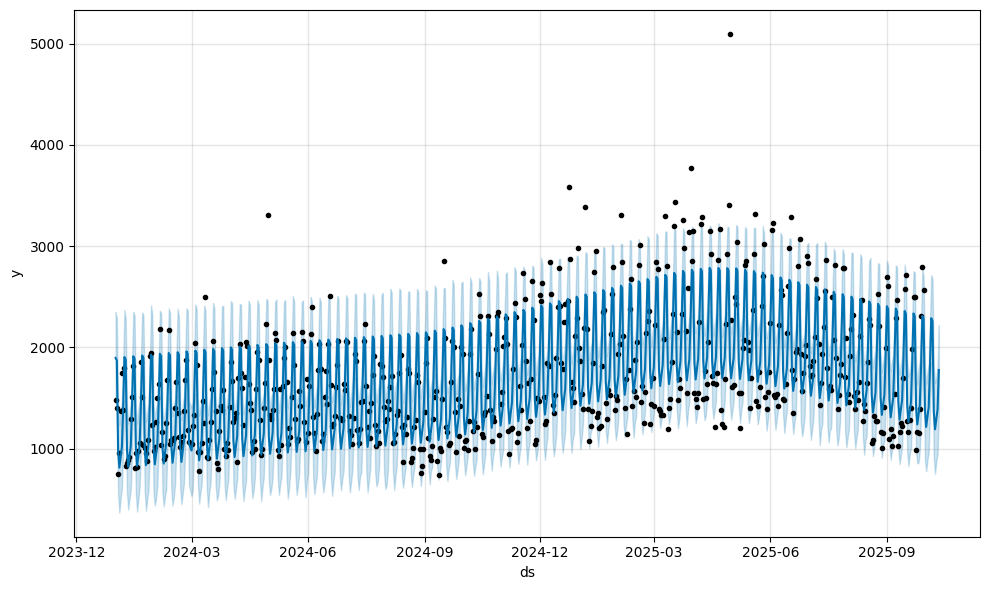

In [10]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

#Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

#Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

#Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

#Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

#Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

#Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

#Gunakan model.make_future_dataframe(periods=7, freq=‚ÄôD‚Äô) untuk membuat dataframe waktu masa depan dan simpan tabel tersebut dalam variabel future
future = model.make_future_dataframe(periods=12, freq='D')

#Lakukan forecasting lagi namun dengan menggunakan dataframe yang baru dibuat
future_prediction = model.predict(future)

#Tampilkan hasil forecasting
fig = model.plot(future_prediction)
plt.show()


           ds      y
0  2024-01-07   9096
1  2024-01-14   8102
2  2024-01-21   8285
3  2024-01-28   8374
4  2024-02-04   9560
..        ...    ...
87 2025-09-07  11279
88 2025-09-14  11116
89 2025-09-21  12398
90 2025-09-28  12002
91 2025-10-05   5357

[92 rows x 2 columns]


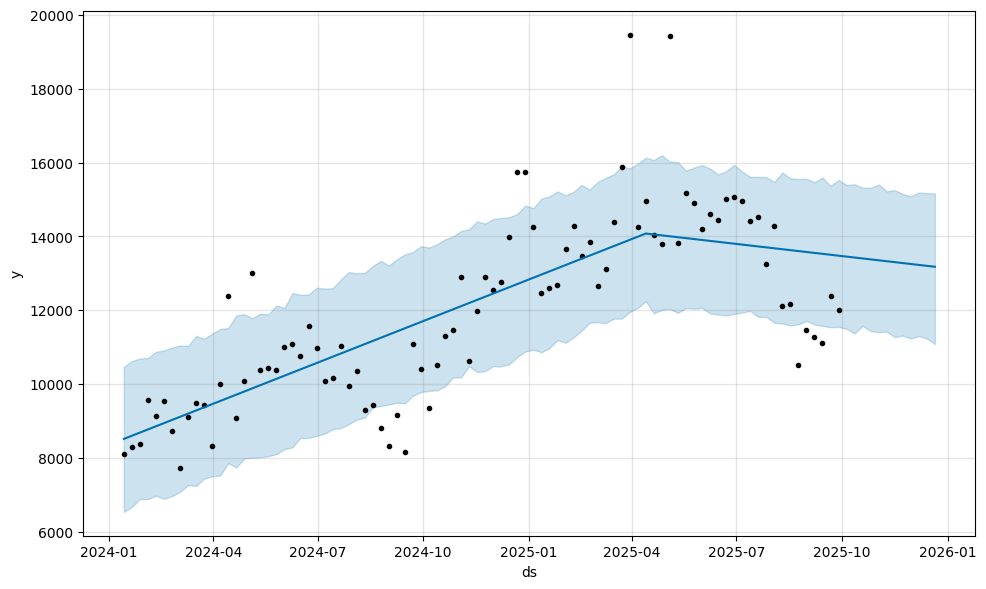

In [11]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

#Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

#Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

#Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

#Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

#Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

#Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

#Gunakan model.make_future_dataframe(periods=7, freq='D') untuk membuat dataframe waktu masa depan dan simpan tabel tersebut dalam variabel future
future = model.make_future_dataframe(periods=7, freq='D')

#Lakukan forecasting lagi namun dengan menggunakan dataframe yang baru dibuat
future_prediction = model.predict(future)

# ---- Model mingguan ----
weekly_prophet_df = prophet_df.resample('W', on='ds')['y'].sum().reset_index()
print(weekly_prophet_df)

# Opsional: buang baris pertama & terakhir
weekly_prophet_df = weekly_prophet_df.iloc[1:-1, :]

# Definisikan model Prophet (pakai kurung!)
weekly_model = Prophet()
weekly_model.fit(weekly_prophet_df)
# Buat future dataframe mingguan (misalnya 12 minggu ke depan)
weekly_future = weekly_model.make_future_dataframe(periods=12, freq='W')

# Forecast mingguan
weekly_prediction = weekly_model.predict(weekly_future)

# Plot hasil forecast mingguan
fig = weekly_model.plot(weekly_prediction)
plt.show()



# Interpretasi Hasil

## 1. Trajektori dan Tren Model
Garis solid berwarna **biru** merepresentasikan proyeksi model atau nilai estimasi, yang menunjukkan tren sentral dari deret waktu.  
Analisis menunjukkan adanya fase **pertumbuhan eksponensial** dari awal tahun **2024** hingga pertengahan **2025**.  
Setelah mencapai titik puncaknya, trajektori model menunjukkan adanya **deselerasi** dan transisi ke fase **plateau** atau bahkan regresi minor menjelang akhir periode prognosis.  

‚û°Ô∏è Pergeseran ini mengindikasikan bahwa laju pertumbuhan yang diobservasi di masa lalu **tidak diproyeksikan berlanjut** pada periode mendatang.

---

## 2. Interval Kepercayaan dan Prediksi
Area berwarna **biru muda** di sekitar garis proyeksi adalah **interval kepercayaan (confidence interval)** atau **interval prediksi**.  
Area ini merefleksikan tingkat **ketidakpastian (uncertainty)** dari estimasi model.  

- Pada periode awal, interval ini relatif **sempit**, menunjukkan presisi prognosis yang tinggi.  
- Seiring semakin jauhnya proyeksi dari data observasi, lebar interval **meningkat signifikan**.  

üìå Ini merupakan karakteristik lazim dalam pemodelan deret waktu, di mana **ketidakpastian prediksi meningkat** seiring dengan perpanjangan horizon waktu.

---

## 3. Data Historis dan Anomali
Titik-titik diskrit berwarna **hitam** merepresentasikan data observasi aktual yang menjadi dasar kalibrasi model.  
Distribusi titik-titik ini menunjukkan pola yang konsisten dengan tren yang diidentifikasi oleh model.  

‚ö†Ô∏è Terdapat beberapa **anomali (outlier)**, seperti titik data di sekitar **April 2025** yang berada di luar rentang nilai umum.  
Meskipun demikian, model prognosis telah dikalibrasi untuk mengikuti **tren agregat** dan **tidak terlalu dipengaruhi** oleh fluktuasi ekstrem atau data anomali tunggal.

---

## üìä Kesimpulan
Secara keseluruhan, model ini memprediksi **pencapaian puncak pertumbuhan** diikuti oleh fase **stabilisasi atau regresi ringan**, dengan **ketidakpastian meningkat** secara eksponensial seiring perpanjangan waktu proyeksi.


In [12]:
# log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

# Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

# Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

# Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

# Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

# Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

# Gunakan model.make_future_dataframe(periods=7, freq='D') untuk membuat dataframe waktu masa depan dan simpan tabel tersebut dalam variabel future
future = model.make_future_dataframe(periods=7, freq='D')

# Lakukan forecasting lagi namun dengan menggunakan dataframe yang baru dibuat
future_prediction = model.predict(future)

# ---- Model mingguan ----
weekly_prophet_df = prophet_df.resample('W', on='ds')['y'].sum().reset_index()

# Opsional: buang baris pertama & terakhir
weekly_prophet_df = weekly_prophet_df.iloc[1:-1, :]

# Definisikan model Prophet (pakai kurung!)
weekly_model = Prophet()
weekly_model.fit(weekly_prophet_df)

# Buat future dataframe mingguan (misalnya 12 minggu ke depan)
weekly_future = weekly_model.make_future_dataframe(periods=12, freq='W')

# Forecast mingguan
weekly_prediction = weekly_model.predict(weekly_future)

# Buat Dataframe baru bernama weekly_combined yang berisi kolom bernama ‚Äòds‚Äô, ‚Äòy_real‚Äô, ‚Äòy_pred‚Äô, ‚Äôresidual‚Äô, dan ‚Äôz_score‚Äô.
weekly_combined = pd.DataFrame(columns=['ds', 'y_real', 'y_pred', 'residual', 'z_score'])

# Assign kolom ‚Äòds‚Äô di dataframe weekly_combined dengan isi di kolom ‚Äòds‚Äô pada dataframe weekly_prophet_df 
weekly_combined['ds'] = weekly_prophet_df['ds'].reset_index(drop=True)

# Assign kolom ‚Äòy_real‚Äô di dataframe weekly_combined dengan isi di kolom ‚Äòy‚Äô pada dataframe weekly_prophet_df
weekly_combined['y_real'] = weekly_prophet_df['y'].reset_index(drop=True)

# Assign kolom ‚Äòy_pred‚Äô di dataframe weekly_combined dengan isi di kolom ‚Äòyhat‚Äô pada dataframe weekly_prediction
weekly_combined['y_pred'] = weekly_prediction['yhat'].reset_index(drop=True)

# Assign kolom ‚Äòresidual‚Äô di dataframe weekly_combined dengan hasil pengurangan kolom ‚Äòy_real‚Äô dengan ‚Äòy_pred‚Äô
weekly_combined['residual'] = weekly_combined['y_real'] - weekly_combined['y_pred']

# Hitung z-score dari residual
weekly_combined['z_score'] = (weekly_combined['residual'] - weekly_combined['residual'].mean()) / weekly_combined['residual'].std()

# Tampilkan dataframe weekly_combined
print(weekly_combined)


           ds  y_real        y_pred     residual   z_score
0  2024-01-14    8102   8515.716144  -413.716144 -0.268345
1  2024-01-21    8285   8601.334072  -316.334072 -0.205238
2  2024-01-28    8374   8686.952001  -312.952001 -0.203047
3  2024-02-04    9560   8772.569929   787.430071  0.510036
4  2024-02-11    9138   8858.187857   279.812143  0.181083
..        ...     ...           ...          ...       ...
85 2025-08-31   11471  13579.150799 -2108.150799 -1.366392
86 2025-09-07   11279  13554.141658 -2275.141658 -1.474607
87 2025-09-14   11116  13529.132518 -2413.132518 -1.564030
88 2025-09-21   12398  13504.123377 -1106.123377 -0.717047
89 2025-09-28   12002  13479.114236 -1477.114236 -0.957460

[90 rows x 5 columns]


## Deteksi Anomali sebuah Data 

Anomali Mingguan:
           ds  y_real        y_pred     residual   z_score
63 2025-03-30   19454  13908.120364  5545.879636  3.593661
68 2025-05-04   19427  14004.180072  5422.819928  3.513914


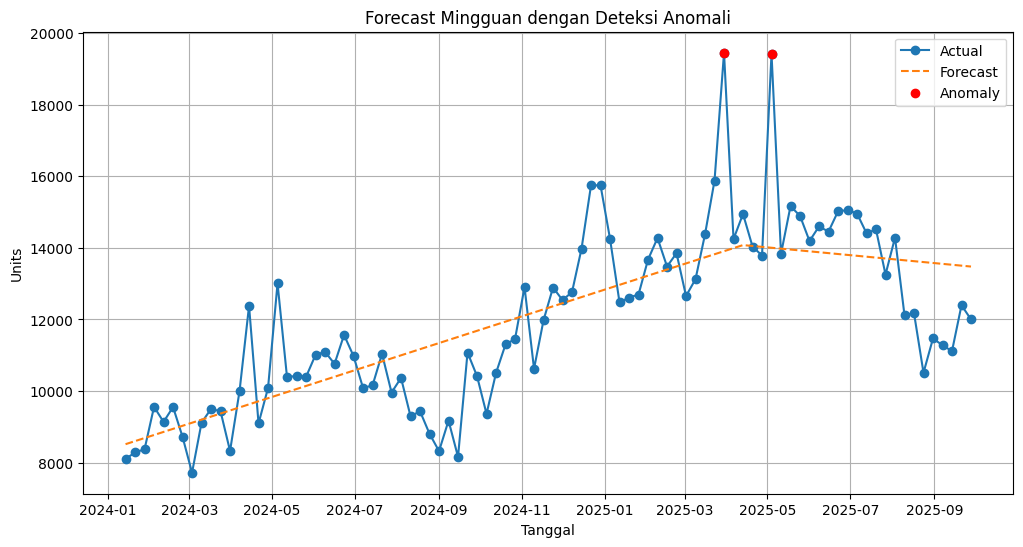

In [13]:
# Supaya log dari Prophet lebih bersih
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Baca dataset
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

# 2. Agregasi total penjualan per hari
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

# 3. Ubah kolom trx_date menjadi datetime
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

# 4. Siapkan dataframe untuk Prophet
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

# 5. Definisikan dan latih model harian
model = Prophet()
model.fit(prophet_df)

# 6. Forecast 30 hari ke depan
future = model.make_future_dataframe(periods=30)
prediction = model.predict(future)

# 7. Forecast ulang untuk 7 hari ke depan
future = model.make_future_dataframe(periods=7, freq='D')
future_prediction = model.predict(future)

# ================================
# ===   MODEL MINGGUAN      ======
# ================================

# 8. Agregasi data mingguan dengan resample
weekly_prophet_df = prophet_df.resample('W', on='ds')['y'].sum().reset_index()

# Opsional: buang baris pertama & terakhir
weekly_prophet_df = weekly_prophet_df.iloc[1:-1, :]

# 9. Definisikan & latih model mingguan
weekly_model = Prophet()
weekly_model.fit(weekly_prophet_df)

# 10. Forecast 12 minggu ke depan
weekly_future = weekly_model.make_future_dataframe(periods=12, freq='W')
weekly_prediction = weekly_model.predict(weekly_future)

# ================================
# ===   DETEKSI ANOMALI     ======
# ================================

# 11. Gabungkan hasil real & prediksi
weekly_combined = pd.DataFrame()
weekly_combined['ds'] = weekly_prophet_df['ds'].reset_index(drop=True)
weekly_combined['y_real'] = weekly_prophet_df['y'].reset_index(drop=True)
weekly_combined['y_pred'] = weekly_prediction['yhat'].reset_index(drop=True)
weekly_combined['residual'] = weekly_combined['y_real'] - weekly_combined['y_pred']

# 12. Hitung rata-rata & standar deviasi residual
res_mean = weekly_combined['residual'].mean()
res_std = weekly_combined['residual'].std()

# 13. Hitung z-score
weekly_combined['z_score'] = (weekly_combined['residual'] - res_mean) / res_std

# 14. Deteksi anomali (abs > 3)
df_anomaly = weekly_combined[weekly_combined['z_score'].abs() > 3]

print("Anomali Mingguan:")
print(df_anomaly)

# ================================
# ===   VISUALISASI ANOMALI ======
# ================================
plt.figure(figsize=(12,6))
plt.plot(weekly_combined['ds'], weekly_combined['y_real'], label='Actual', marker='o')
plt.plot(weekly_combined['ds'], weekly_combined['y_pred'], label='Forecast', linestyle='--')

# Highlight anomali
plt.scatter(df_anomaly['ds'], df_anomaly['y_real'], color='red', label='Anomaly', zorder=5)

plt.xlabel("Tanggal")
plt.ylabel("Units")
plt.title("Forecast Mingguan dengan Deteksi Anomali")
plt.legend()
plt.grid(True)
plt.show()


           ds  y_real        y_pred     residual   z-score
63 2025-03-30   19454  13908.120364  5545.879636  3.593661
68 2025-05-04   19427  14004.180072  5422.819928  3.513914


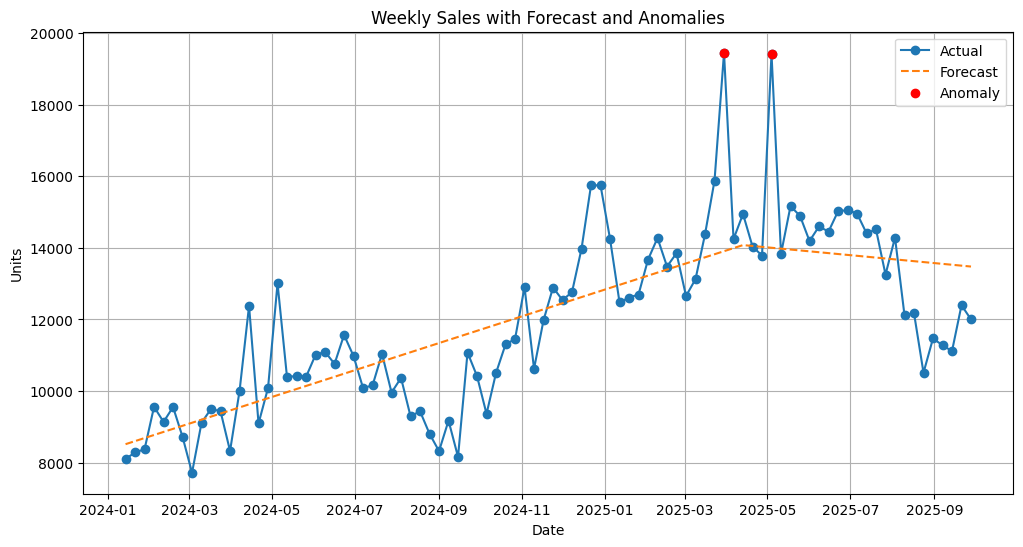

In [14]:
# Log yang dihasilkan oleh library Prophet sebagai error.
import logging
logging.getLogger('cmdstanpy').disabled = True

# Import library
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Baca dan tampilkan dataset ‚Äúsales.csv‚Äù menggunakan read_csv dari library pandas.
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/sales.csv")

# Agregasi tabel dalam bentuk total penjualan per hari dan simpan ke dataframe baru dengan nama ‚Äúsales_by_date‚Äù
sales_by_date = df.groupby('trx_date')['units'].sum().reset_index()

# Ubah tipe data kolom waktu menjadi tipe waktu
sales_by_date["trx_date"] = pd.to_datetime(sales_by_date["trx_date"])

# Ubah nama kolom waktu menjadi ‚Äúds‚Äù dan nama kolom nilai menjadi ‚Äúy‚Äù, simpan hasilnya ke dataframe baru dengan nama ‚Äúprophet_df‚Äù
prophet_df = sales_by_date.rename(columns={'trx_date': 'ds', 'units': 'y'})

# Definisikan model prophet dan simpan dalam variable ‚Äòmodel‚Äô
model = Prophet()

# Training model prophet dengan data yang sudah dirapikan dengan menggunakan atribut .fit
model.fit(prophet_df)

# Buat future dataframe untuk 30 hari ke depan
future = model.make_future_dataframe(periods=30)

# Forecasting
prediction = model.predict(future)

# Gunakan model.make_future_dataframe(periods=7, freq='D') untuk membuat dataframe waktu masa depan
future = model.make_future_dataframe(periods=7, freq='D')

# Lakukan forecasting lagi dengan dataframe baru
future_prediction = model.predict(future)

# ---- Model mingguan ----
# Agregasi data mingguan
weekly_prophet_df = prophet_df.resample('W', on='ds')['y'].sum().reset_index()

# Opsional: buang baris pertama & terakhir
weekly_prophet_df = weekly_prophet_df.iloc[1:-1, :]

# Definisikan model Prophet
weekly_model = Prophet()
weekly_model.fit(weekly_prophet_df)

# Buat future dataframe mingguan (12 minggu ke depan)
weekly_future = weekly_model.make_future_dataframe(periods=12, freq='W')

# Forecast mingguan
weekly_prediction = weekly_model.predict(weekly_future)

# Buat Dataframe baru bernama weekly_combined
weekly_combined = pd.DataFrame(columns=['ds', 'y_real', 'y_pred', 'residual', 'z-score'])

# Isi kolom dataframe
weekly_combined['ds'] = weekly_prophet_df['ds'].reset_index(drop=True)
weekly_combined['y_real'] = weekly_prophet_df['y'].reset_index(drop=True)
weekly_combined['y_pred'] = weekly_prediction['yhat'].reset_index(drop=True)
weekly_combined['residual'] = weekly_combined['y_real'] - weekly_combined['y_pred']

# Hitung rata-rata dan standar deviasi residual
res_mean = weekly_combined['residual'].mean()
res_std = weekly_combined['residual'].std()

# Hitung z-score
weekly_combined['z-score'] = (weekly_combined['residual'] - res_mean) / res_std

# Tentukan anomali (nilai absolut z-score > 3)
df_anomaly = weekly_combined[weekly_combined['z-score'].abs() > 3]

# Tampilkan dataframe anomali
print(df_anomaly)

# ---- Plotting ----
plt.figure(figsize=(12, 6))
plt.plot(weekly_combined['ds'], weekly_combined['y_real'], label='Actual', marker='o')
plt.plot(weekly_combined['ds'], weekly_combined['y_pred'], label='Forecast', linestyle='--')
plt.scatter(df_anomaly['ds'], df_anomaly['y_real'], color='red', label='Anomaly', zorder=5)
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Weekly Sales with Forecast and Anomalies')
plt.legend()
plt.grid(True)
plt.show()
